In [17]:

import pandas as pd
import sys
import os
from datetime import timedelta 
module_path = os.path.abspath(os.path.join('..', 'src'))
if module_path not in sys.path:
    sys.path.append(module_path)

import data_processing
import financial_analysis
import visualization_tools 

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="pastel") 
plt.rcParams['figure.figsize'] = (14, 7) 
plt.rcParams['font.size'] = 12            

print("Cell 1: Imports and basic setup complete.")



Cell 1: Imports and basic setup complete.


In [18]:

NEWS_DATA_FILE = '../data/raw_analyst_ratings.csv'

DATE_COL_NEWS_CONTEXT = 'date'    
STOCK_COL_NEWS_CONTEXT = 'stock'  

STOCK_CSV_DIRECTORY = '../data/raw/stock_historical_data/' 
FILENAME_TEMPLATE = "{}_historical_data.csv"  
DATE_COL_IN_STOCK_CSV = 'Date'                
PRICE_COL_FOR_TA = 'Close'                    
REQUIRED_OHLCV_COLS = ['Open', 'High', 'Low', 'Close', 'Volume']


print("Cell 2: Configuration for data paths and column names set.")

Cell 2: Configuration for data paths and column names set.


In [19]:

print("\n--- Cell 3: Loading News Data for Context ---")
news_df_raw = data_processing.load_financial_news_data(NEWS_DATA_FILE)

if not news_df_raw.empty:
    if DATE_COL_NEWS_CONTEXT not in news_df_raw.columns:
    
       
        news_df_processed_context = pd.DataFrame() 
    else:
        news_df_processed_context = data_processing.extract_date_features(news_df_raw, date_col=DATE_COL_NEWS_CONTEXT)

    if news_df_processed_context.empty or STOCK_COL_NEWS_CONTEXT not in news_df_processed_context.columns or news_df_processed_context[STOCK_COL_NEWS_CONTEXT].isnull().all():
       
        valid_tickers_for_stock_loading = ['AAPL', 'MSFT', 'GOOG'] 
        start_date_news_context = '2023-01-01' 
        end_date_news_context = '2023-12-31'  
    else:
      
        unique_tickers_from_news = news_df_processed_context[STOCK_COL_NEWS_CONTEXT].dropna().astype(str).str.upper().unique().tolist()
       
        valid_tickers_for_stock_loading = [t for t in unique_tickers_from_news if t.isalnum() and 0 < len(t) <= 5]
        if not valid_tickers_for_stock_loading:
            valid_tickers_for_stock_loading = ['AAPL', 'MSFT', 'GOOG'] 

    
        if 'publication_date_only' in news_df_processed_context.columns and not news_df_processed_context['publication_date_only'].isnull().all():
            start_date_news_context = news_df_processed_context['publication_date_only'].min().strftime('%Y-%m-%d')
            end_date_news_context = news_df_processed_context['publication_date_only'].max().strftime('%Y-%m-%d')
        else:
           
            start_date_news_context = '2023-01-01'
            end_date_news_context = '2023-12-31'
    context_loaded_successfully = True
else:
   
    valid_tickers_for_stock_loading = ['AAPL', 'MSFT', 'GOOG'] 
    start_date_news_context = '2023-01-01' 
    end_date_news_context = '2023-12-31'   
    context_loaded_successfully = False 

print("Cell 3: News data context loaded (or fallback used).")


--- Cell 3: Loading News Data for Context ---
Cell 3: News data context loaded (or fallback used).


In [21]:
# Cell 4: Load Stock Price Data from CSVs
print("\n--- Cell 4: Loading Stock Price Data from CSVs ---")
if valid_tickers_for_stock_loading:
    all_stock_data = financial_analysis.load_stock_prices_from_csvs(
        tickers=valid_tickers_for_stock_loading, 
        csv_directory=STOCK_CSV_DIRECTORY,
        filename_template=FILENAME_TEMPLATE,
        date_col=DATE_COL_IN_STOCK_CSV,
        required_ohlcv_cols=REQUIRED_OHLCV_COLS
    )

    if not all_stock_data: 
        stock_data_loaded_successfully = False
    else:
        stock_data_loaded_successfully = True
else:
    stock_data_loaded_successfully = False

print("Cell 4: Stock price data loading complete.")


--- Cell 4: Loading Stock Price Data from CSVs ---
Attempting to load stock data from CSVs in directory: ../data/raw/stock_historical_data/
Using filename template: {}_historical_data.csv and date column: Date
Cell 4: Stock price data loading complete.


In [22]:

print("\n--- Cell 5: Calculating Technical Indicators ---")
stock_data_with_indicators = {}

if stock_data_loaded_successfully:
    for ticker_symbol, df_stock_loaded in all_stock_data.items(): 
        if PRICE_COL_FOR_TA not in df_stock_loaded.columns:
            print(f"Price column '{PRICE_COL_FOR_TA}' not found for TA in {ticker_symbol}'s data. Skipping TA for this stock.")
            stock_data_with_indicators[ticker_symbol] = df_stock_loaded # Store original data without TAs
            continue
        
        stock_data_with_indicators[ticker_symbol] = financial_analysis.calculate_technical_indicators(
            df_stock_loaded, price_col=PRICE_COL_FOR_TA
        )
else:
    print("Stock data was not loaded successfully. Skipping TA calculation.")

print("Cell 5: Technical indicator calculation complete.")


--- Cell 5: Calculating Technical Indicators ---
Cell 5: Technical indicator calculation complete.



--- Cell 6: Visualizing Stock Data with Indicators ---
Preparing plot for AAPL...


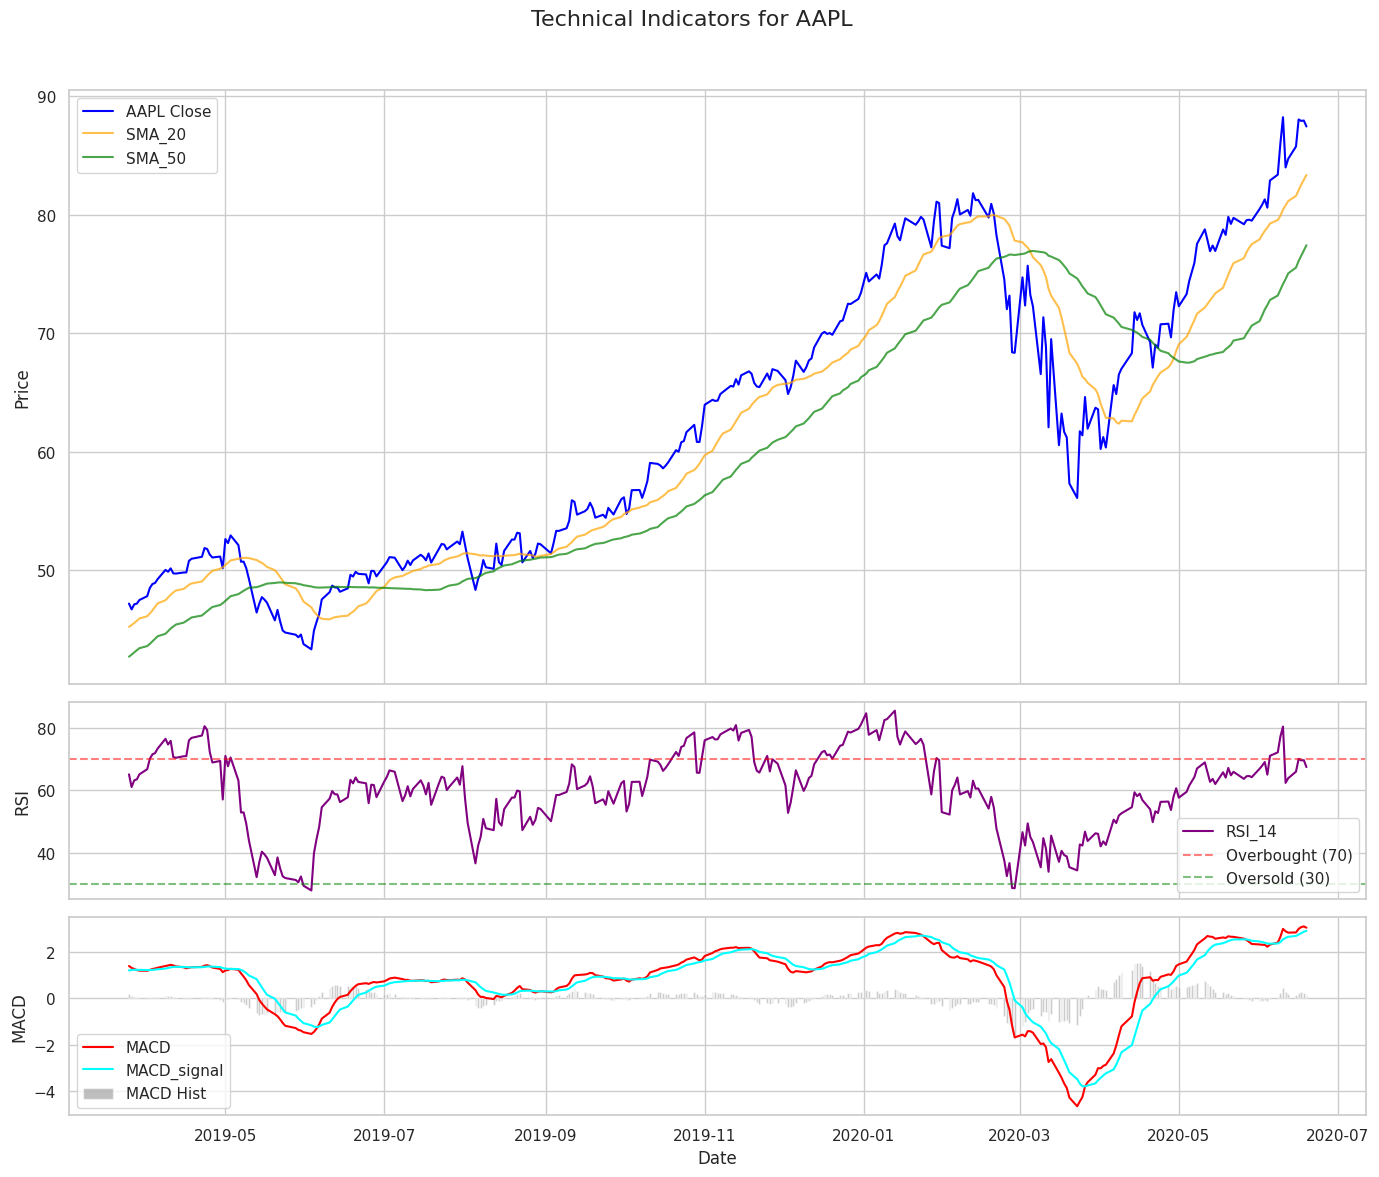

Preparing plot for AMZN...


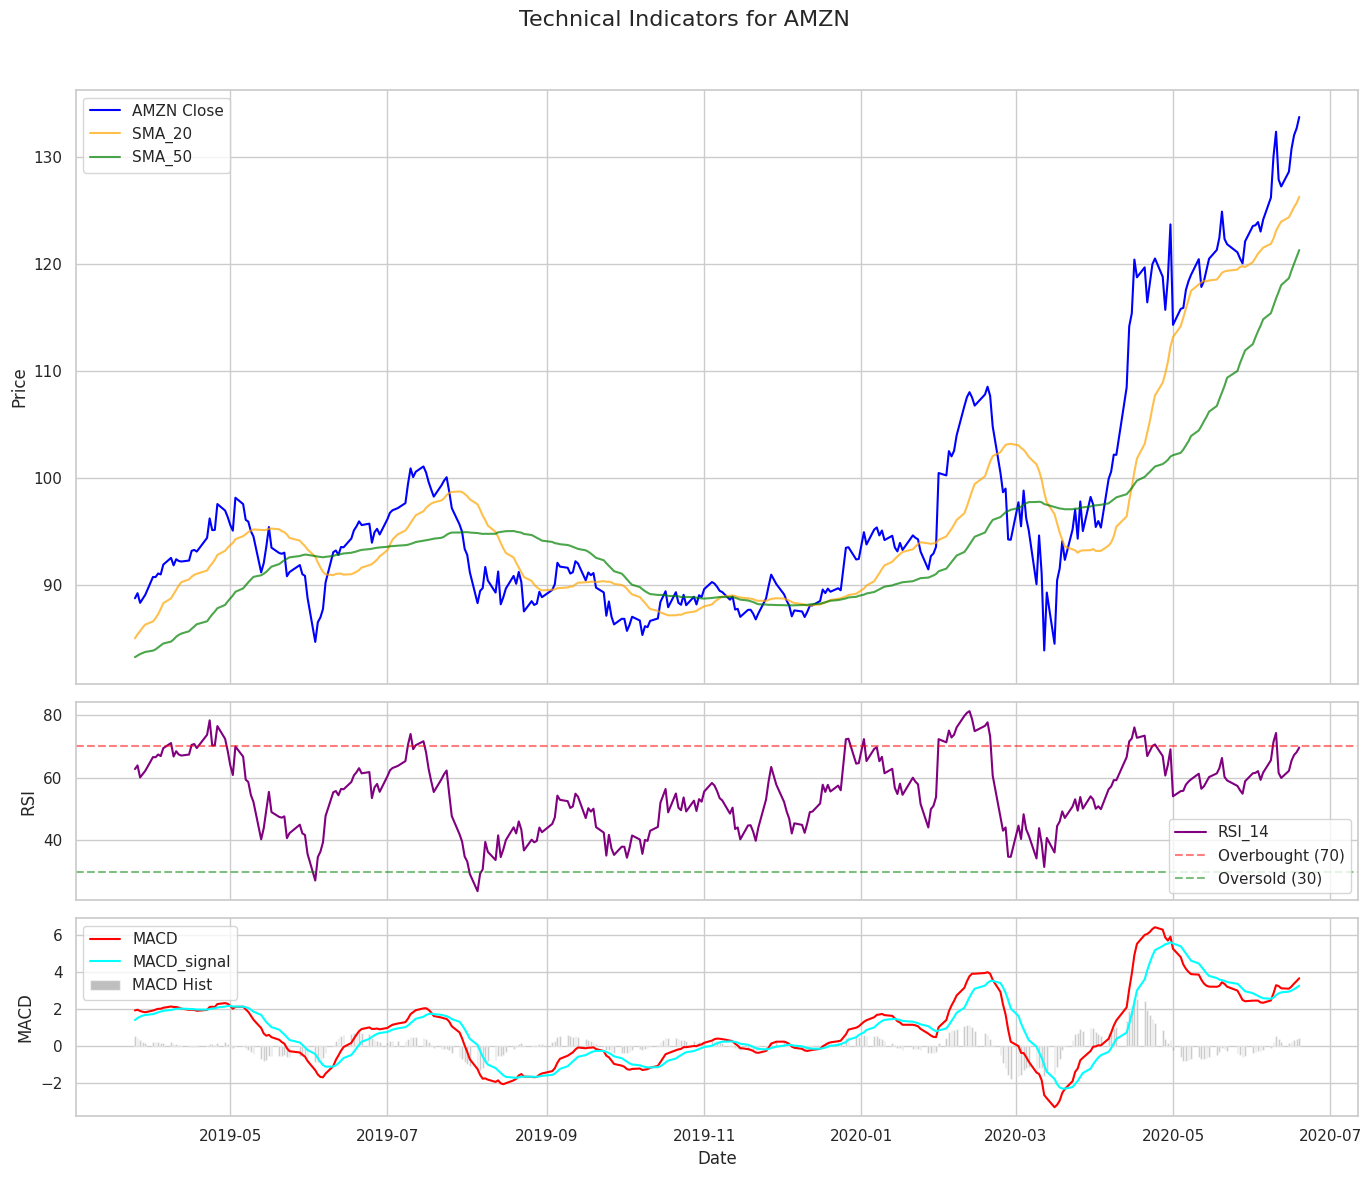

Preparing plot for GOOG...


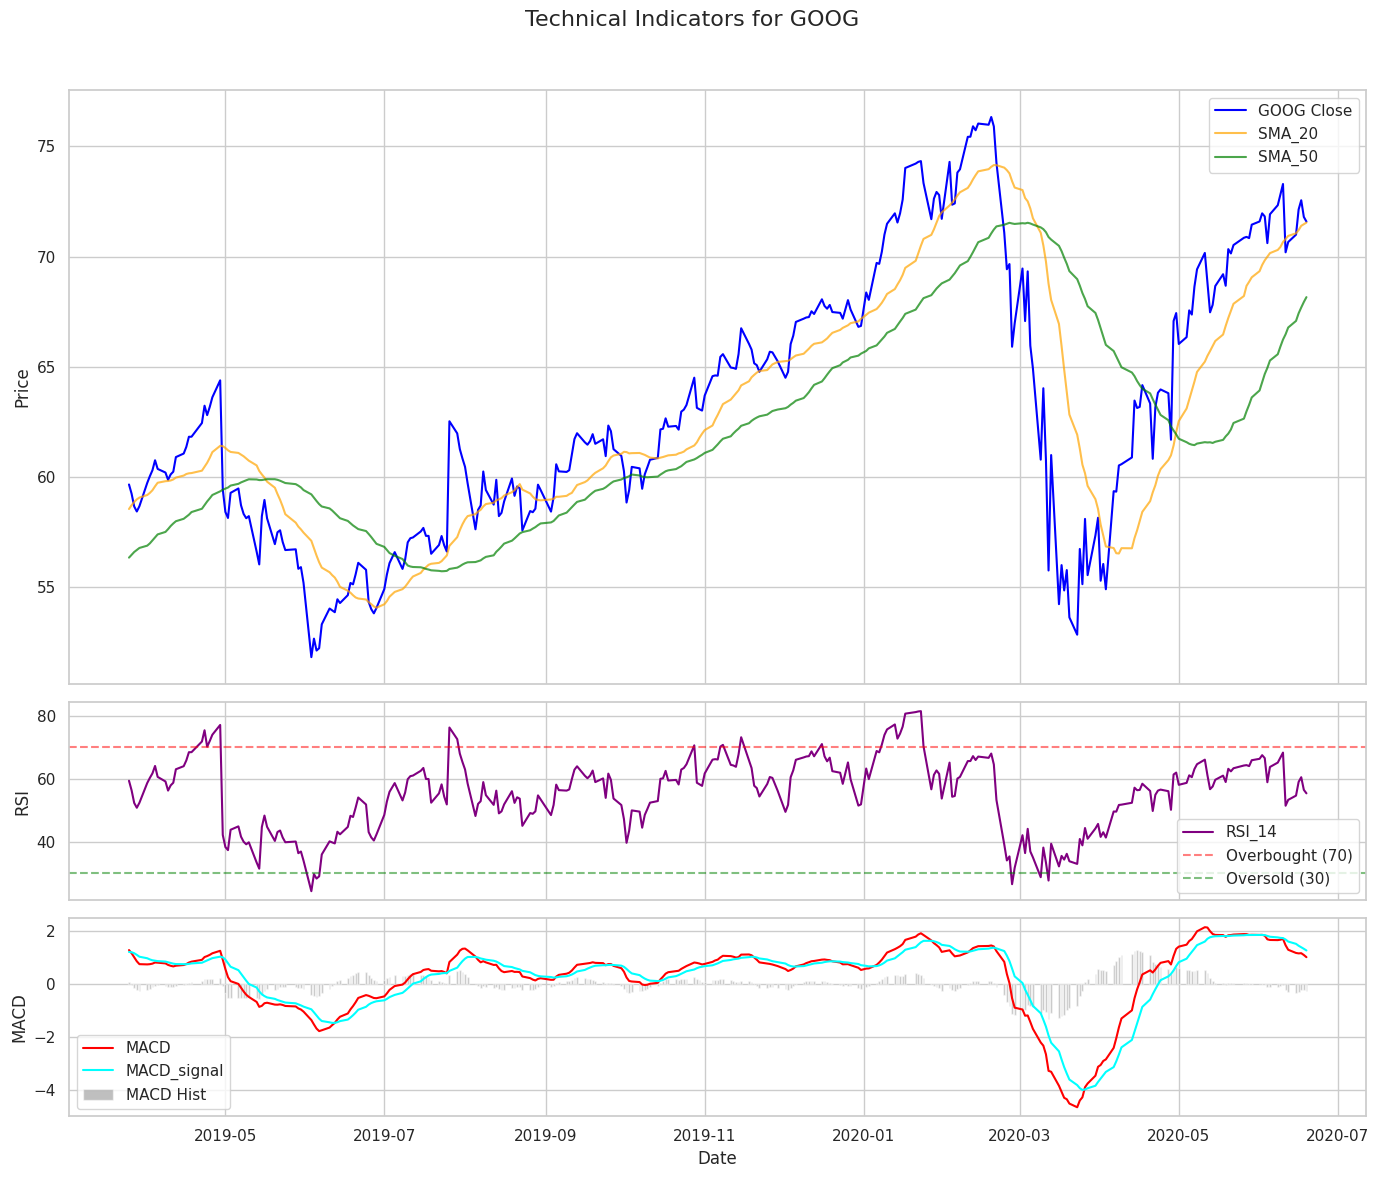

Preparing plot for NVDA...


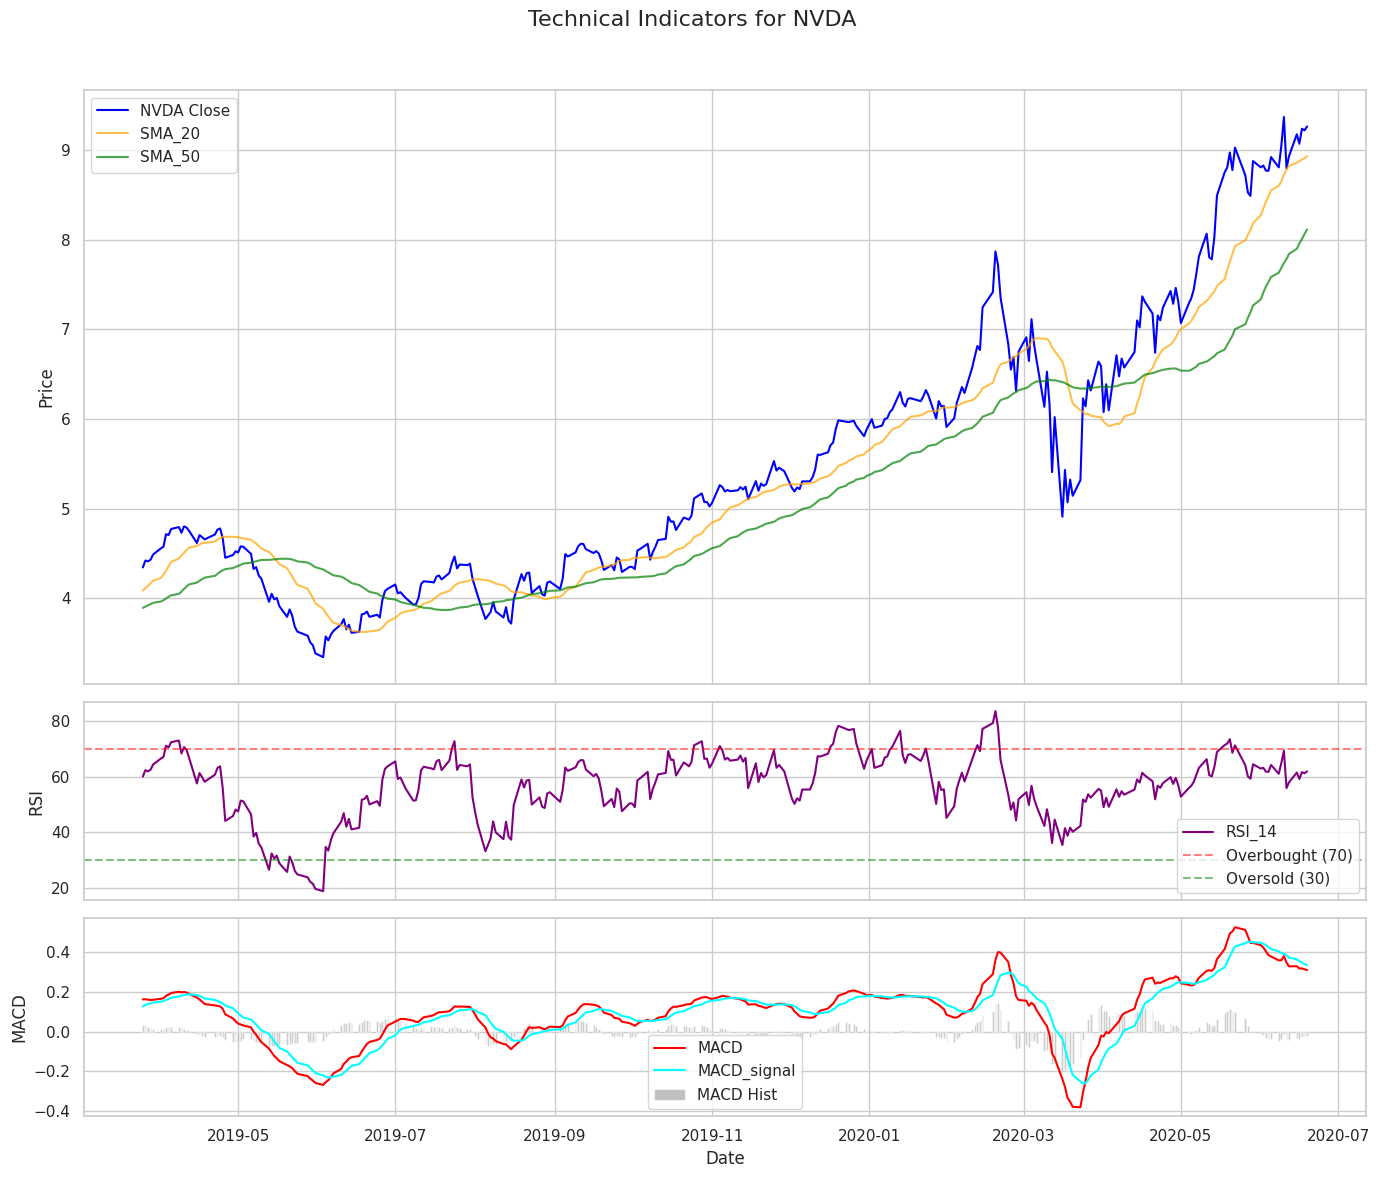

Preparing plot for TSLA...


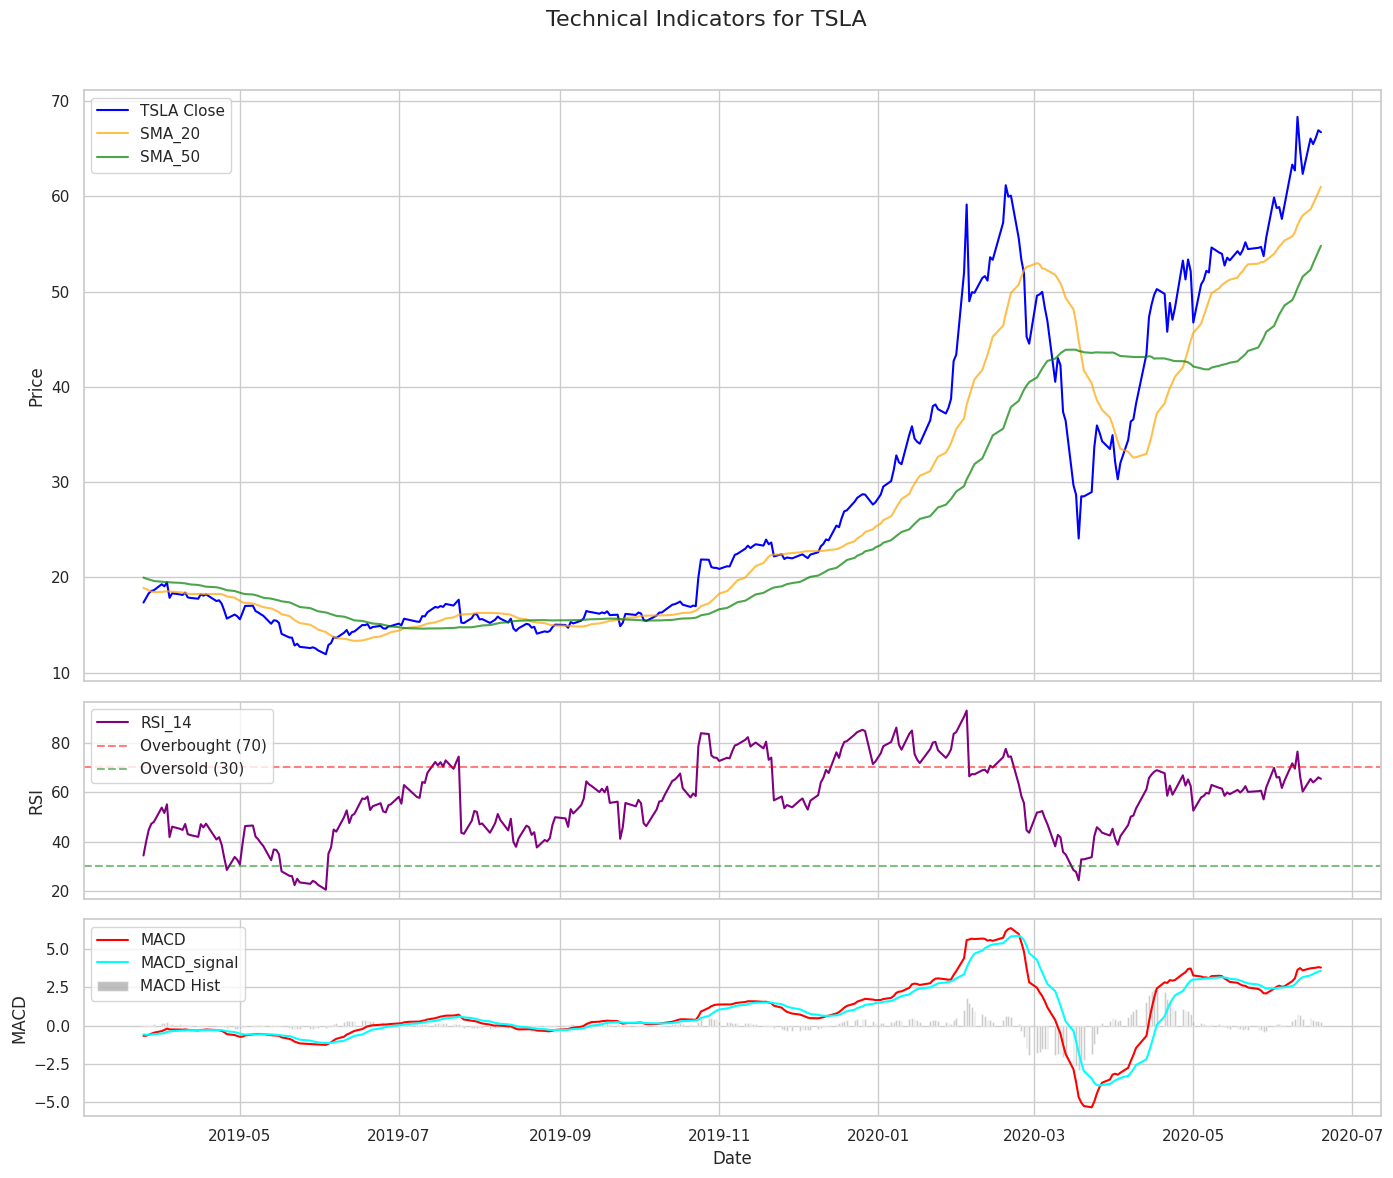


--- Quantitative Analysis (Task 2) complete. ---
Cell 6: Visualization complete.


In [ ]:

print("\n--- Cell 6: Visualizing Stock Data with Indicators ---")

if stock_data_with_indicators:
    tickers_plotted_count = 0
    max_tickers_to_plot = 7

    for ticker_to_plot, df_plot_data_with_tas in stock_data_with_indicators.items():
        if tickers_plotted_count >= max_tickers_to_plot:
            print(f"Reached max number of plots ({max_tickers_to_plot}). Stopping visualization here.")
            break

        if PRICE_COL_FOR_TA not in df_plot_data_with_tas.columns:
            print(f"Skipping plot for {ticker_to_plot}: Price column '{PRICE_COL_FOR_TA}' not found in its data.")
            continue
        
        if df_plot_data_with_tas[PRICE_COL_FOR_TA].dropna().empty:
            print(f"No valid price data to plot for {ticker_to_plot} after TA NaNs. Skipping plot.")
            continue

        print(f"Preparing plot for {ticker_to_plot}...")
        plot_window_end_dt = pd.to_datetime(end_date_news_context) + timedelta(days=10) 
        plot_window_start_dt = plot_window_end_dt - timedelta(days=365 + 90)

        df_plot_filtered = df_plot_data_with_tas[
            (df_plot_data_with_tas.index >= plot_window_start_dt) &
            (df_plot_data_with_tas.index <= plot_window_end_dt)
        ]

        if not df_plot_filtered.empty:
        
            if hasattr(visualization_tools, 'plot_stock_with_indicators') and callable(visualization_tools.plot_stock_with_indicators):
                 visualization_tools.plot_stock_with_indicators(
                    df_plot_filtered, ticker_to_plot, price_col=PRICE_COL_FOR_TA
                )
            else:
                print(f"Error: 'plot_stock_with_indicators' not found in visualization_tools module. Cannot plot.")
                plt.figure()
                df_plot_filtered[PRICE_COL_FOR_TA].plot(title=f"{ticker_to_plot} - {PRICE_COL_FOR_TA} (Basic Plot)")
                plt.show()

            tickers_plotted_count += 1
        else:
            print(f"No data in the defined plotting window ({plot_window_start_dt.date()} to {plot_window_end_dt.date()}) for {ticker_to_plot}. Skipping plot.")
else:
    print("No data with indicators available to visualize (all_stock_data might have been empty or TAs failed for all).")

print("\n--- Quantitative Analysis (Task 2) complete. ---")
print("Cell 6: Visualization complete.")